# Krypton waveform NB

- Chamber at 10 bar fixed time shift

## Imports

In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2018-03-16 13:38:19


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pkf
import invisible_cities.reco.calib_sensors_functions as csf
from   invisible_cities.reco.xy_algorithms      import corona

from   invisible_cities.evm.ic_containers  import S12Params 
from   invisible_cities.evm.ic_containers  import CalibVectors
from   invisible_cities.evm.ic_containers  import DeconvParams
from   invisible_cities.evm.ic_containers  import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.core.core_functions import loc_elem_1d
from   invisible_cities.types.ic_types import minmax
import invisible_cities.icaro.mpl_functions as mpl
import invisible_cities.icaro.signal_functions_mpl as sf
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.sierpe                 import blr

In [4]:
from invisible_cities.reco.dst_functions  import load_dst

In [5]:
from invisible_cities.evm .pmaps             import S1
from invisible_cities.evm .pmaps             import S2

In [6]:
from typing      import NamedTuple

## NB functions

In [7]:
def plot_S12(s12s):
    plt.grid(True)
    plt.xlabel(r't (ns)')
    plt.ylabel(r'q (pes)')
    for s12 in s12s:
        plt.plot(s12.times, s12.pmts.waveform(-1))

In [8]:
def plot_pmt_signals_vs_time_mus(pmt_signals,
                                 pmt_active,
                                 t_min      =    0,
                                 t_max      = 1200,
                                 signal_min =    0,
                                 signal_max =  200,
                                 figsize=(12,12)):
    """Plot PMT signals versus time in mus  and return figure."""

    tstep = 25
    PMTWL = pmt_signals[0].shape[0]
    signal_t = np.arange(0., PMTWL * tstep, tstep)/units.mus
    plt.figure(figsize=figsize)
   
   
    plt.ylabel(r'q (pes/adc)')
    for j, i in enumerate(pmt_active):
        plt.grid(True)
        ax1 = plt.subplot(3, 4, j+1)
        ax1.set_xlim([t_min, t_max])
        ax1.set_ylim([signal_min, signal_max])
        plt.plot(signal_t, pmt_signals[i])
        plt.xlabel(r't (mus)')


In [9]:
def plot_pmt_waveforms(pmtwfdf, first=0, last=50000, figsize=(10,10)):
    """plot PMT wf and return figure"""
    plt.figure(figsize=figsize)
    for i in range(len(pmtwfdf)):
        ax = plt.subplot(3, 4, i+1)
        plt.xlabel(r't (mus)')
        plt.plot(pmtwfdf[i][first:last])


In [10]:
def plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min, t_max):

    sipm_sums = np.sum(sipm_cal, axis=0)
    
    t = np.arange(len(cwf_sum)) / 40
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(t, cwf_sum)
    plt.xlim(t_min , t_max )

    plt.subplot(2, 1, 2)
    plt.plot(sipm_sums)
    plt.xlim(t_min, t_max)


In [11]:
def plot_sipm_map(sipm_cal, t_min=0, t_max=1300, zoom=False):
    
    sipm_sums_w = np.sum(sipm_cal[:, t_min:t_max], axis=1)
    
    plt.figure()
    sipms_ = sipm_sums_w > 0 
    x = xs[sipms_]
    y = ys[sipms_]
    q = sipm_sums_w[sipms_]
    print(np.argwhere(sipms_))
    plt.scatter(x, y, s=10, c=q, cmap="jet")
    
    if not zoom:
        plt.xlim(-200, 200)
        plt.ylim(-200, 200)
    plt.colorbar()

In [12]:
def display_s12s(s12s):
    for s12 in s12s:
        print('energy = {} pes charge = {} pes time = {} mus width = {} ns'.format(
        s12.total_energy, s12.total_charge, s12.time_at_max_energy/units.mus, s12.width))

In [13]:
def plot_sipm_signals_vs_time_mus(sipm_signals,
                                  sipm_min      =    0,
                                  sipm_max      = 2000,
                                 figsize=(6,6)):
    """Plot PMT signals versus time in mus  and return figure."""


    plt.figure(figsize=figsize)   
    plt.ylabel(r'q (pes/adc)')
    plt.xlabel(r'sipm number ')
    ax = plt.subplot()
    ax.set_xlim([sipm_min, min(sipm_max, len(sipm_signals))])
    plt.grid(True)
    plt.plot(sipm_signals)
       


In [14]:
def sort_s12s(s12s):
    return sorted(s12s, key= lambda s12 : s12.total_energy, reverse=True)

In [15]:
def kr_dst(s1s, s2s, xs, ys):
    s1 = sort_s12s(s1s)[0]
    s2 = sort_s12s(s2s)[0]
    c = compute_xy_peak_position(s2.sipms, xs, ys)
    
    return KrDst(es1 = s1.total_energy, ws1=s1.width, 
                 es2 =s2.total_energy,  ws2=s1.width, qs2=s2.total_charge, 
                 dt = (s2.time_at_max_energy - s1.time_at_max_energy) / units.mus,
                 c = c)
    

In [16]:
class Cluster(NamedTuple):
    Q     : float
    x     : float 
    y     : float
    nsipm : int

In [17]:
class KrDst(NamedTuple):
    es1  : float
    ws1  : float
    es2  : float
    ws2  : float
    qs2  : float
    dt   : float 
    c    : Cluster


In [18]:
def compute_xy_peak_position(sr, xs, ys):
        """
        Computes position using the integral of the charge
        in each SiPM. Config parameters set equal to the standard kDST values.
        """
        IDs = sr.ids
        Qs = sr.sum_over_times
        xs, ys   = xs[IDs], ys[IDs]
        cls      = corona(np.stack((xs, ys), axis=1), Qs,
                      Qthr           =  1.,
                      Qlm            =  0.,
                      lm_radius      =  -1.,
                      new_lm_radius  =  -1.,
                      msipm          =  1)
        c = cls[0]
        return Cluster(Q=c.Q, x=c._xy.x, y=c._xy.y, nsipm=c.nsipm)


In [19]:
KR = []

## Data base

In [40]:
run_number = 5425
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [21]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [22]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,0,PMT1,1,-23.9414,65.7785,0.000530,4.250400e-07,21.33,0.77,11.33
1,1,12,PMT3,1,-44.9951,-53.6231,0.000533,3.599900e-07,23.37,0.00,11.54
2,2,1,PMT2,1,68.9365,-12.1554,0.000530,5.525500e-07,26.02,0.81,10.62
3,3,13,PMT4,1,0.0000,185.0000,0.000526,3.563900e-07,25.74,0.00,11.86
4,4,19,PMTC,1,-118.9160,141.7180,0.000520,3.804100e-07,30.00,0.75,13.15
5,5,18,PMTB,1,-182.1890,32.1249,0.000529,5.704900e-07,22.66,0.75,9.88
6,6,7,PMTA,1,-160.2150,-92.5000,0.000518,5.597400e-07,25.09,0.00,11.04
7,7,6,PMT9,1,-63.2737,-173.8430,0.000528,5.918400e-07,32.66,0.00,14.72
8,8,2,PMT8,1,63.2737,-173.8430,0.000525,4.849600e-07,23.10,0.00,10.60
9,9,16,PMT7,1,160.2150,-92.5000,0.000527,4.763500e-07,25.47,0.00,10.37


In [23]:
channel_id

array([ 0, 12,  1, 13, 19, 18,  7,  6,  2, 16,  5,  4])

In [24]:
sipm_adc_to_pes = DataSiPM.adc_to_pes.values

In [25]:
sipm_adc_to_pes[181] = 0

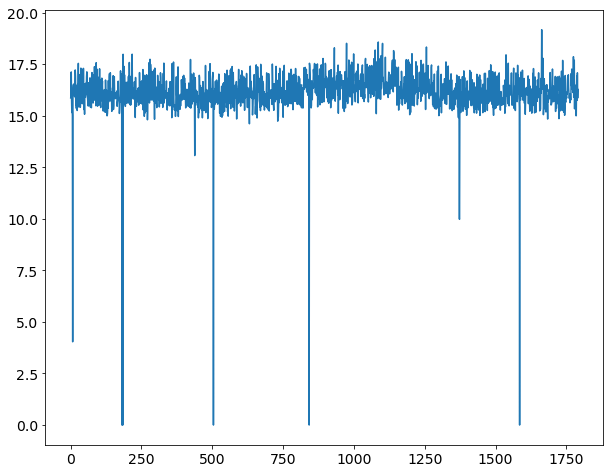

In [26]:
plt.plot(sipm_adc_to_pes)

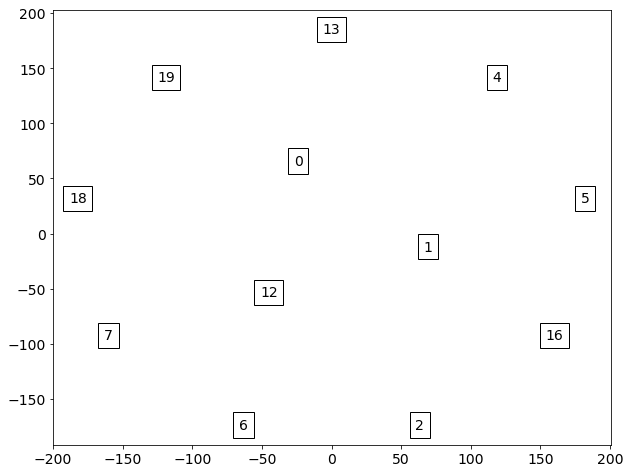

In [27]:
mpl.draw_pmt_map(run_number)

In [28]:
adc_to_pes

array([ 21.33,  23.37,  26.02,  25.74,  30.  ,  22.66,  25.09,  32.66,
        23.1 ,  25.47,  20.8 ,  21.99])

## Input file

In [29]:
filename = f'/Users/jjgomezcadenas/Projects/ICDEV/data/{run_number}/run_{run_number}_0000_waveforms.h5'
input_files = [filename]
h5rwf = tb.open_file(filename, "r") 

In [30]:
pmtrwf = h5rwf.root.RD.pmtrwf
sipmrwf = h5rwf.root.RD.sipmrwf
NEVT, NPMT, PMTWL = pmtrwf.shape
_, NSIPM, SIPMWL = sipmrwf.shape

In [31]:
NEVT, NPMT, PMTWL = pmtrwf.shape

In [32]:
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL, NSIPM, SIPMWL))


        Number of events in file = 164
        Number of PMTs = 12
        PMTWL = 52000
        Number of SiPMs = 1792
        SiPMWL = 1300
      


## S1 and S2 parameters

In [33]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)

In [34]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)

## Events

### Event

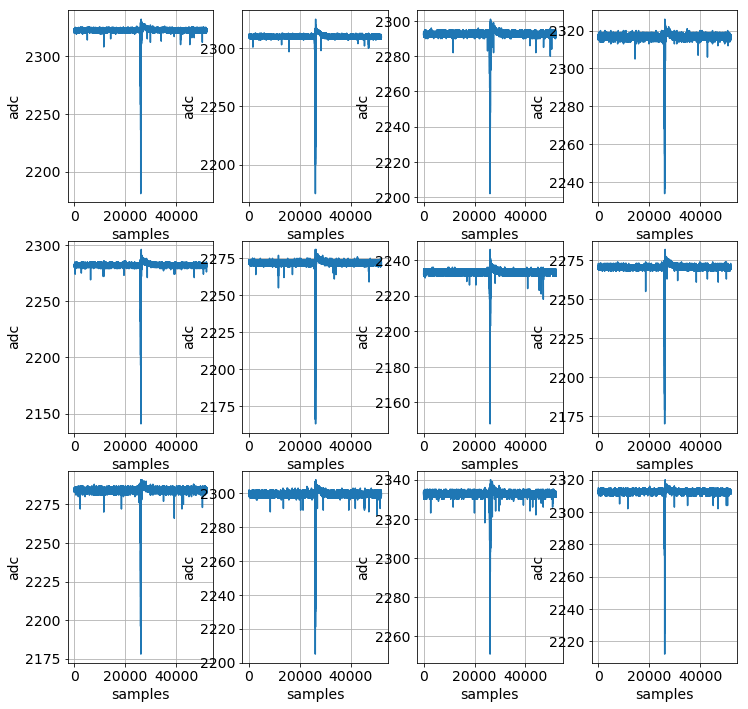

In [35]:
event=0
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

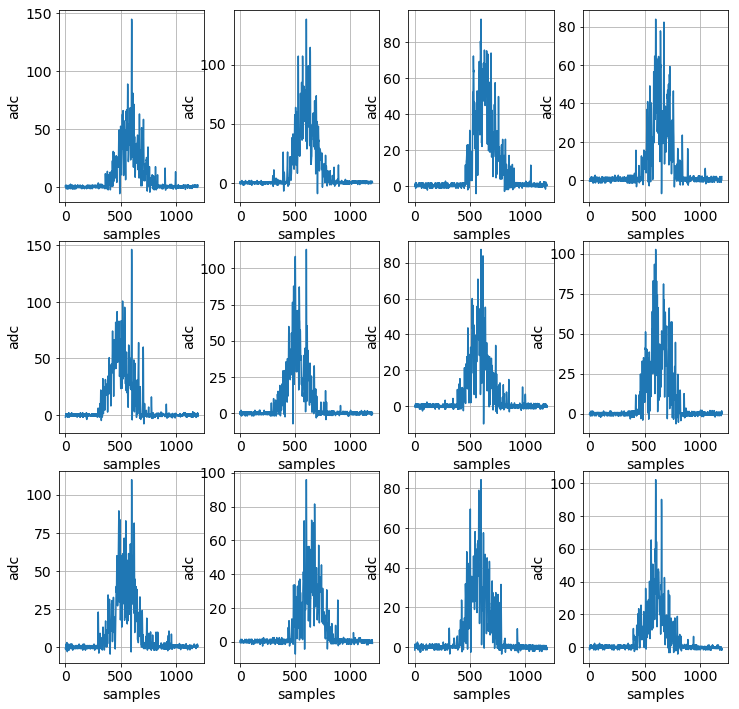

In [36]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=600, figsize=(12,12))

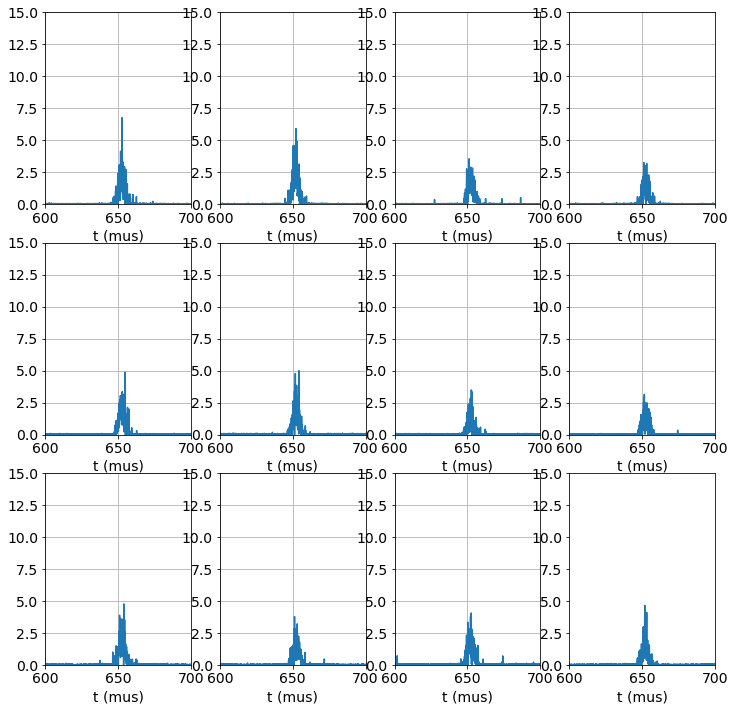

In [37]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    600,
                                t_max      = 700,
                                signal_min =    0,
                                signal_max =  15,
                                 figsize=(12,12))

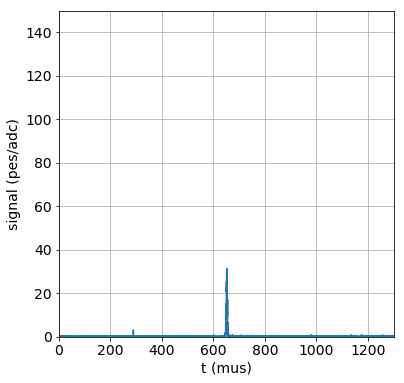

In [38]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  150,
                            figsize=(6,6))

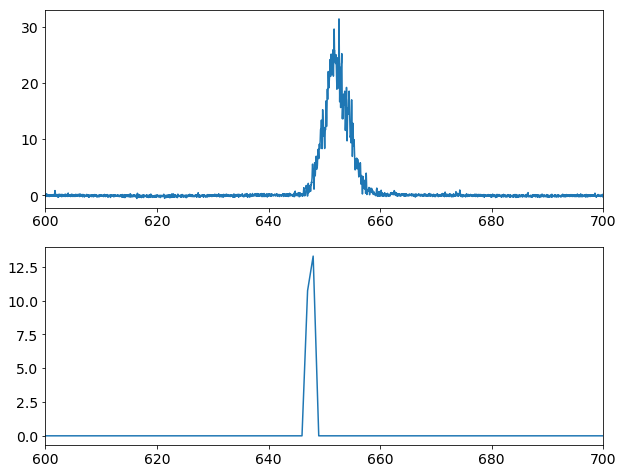

In [39]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=600, t_max=700)

In [41]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 11
       Times: [ 289.275  289.3    289.325  289.35   289.375  289.4    289.425  289.45
 289.475  289.5    289.525] µs
       Time @ max energy: 289.325
       Width: 0.25 µs
       Height: 3.1747675745509154 pes
       Energy: 14.251280016470231 pes
       Charge: 0.0 pes
       RMS: 0.06866243264228723 µs]

In [42]:
s2params = S12Params(time = minmax(min    = 600 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 40, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 646.68952881  647.66092988  648.56201969  649.51836382  650.55903513
 651.50003323  652.47376978  653.45433367  654.47438662  655.42110319
 656.39176525  657.40563505  658.4193761   659.30803651] µs
       Time @ max energy: 651.5000332290584
       Width: 12.61850770153536 µs
       Height: 954.1811927763187 pes
       Energy: 4980.634789261311 pes
       Charge: 24.022642618468048 pes
       RMS: 2.137868673467065 µs]

[[1748]]


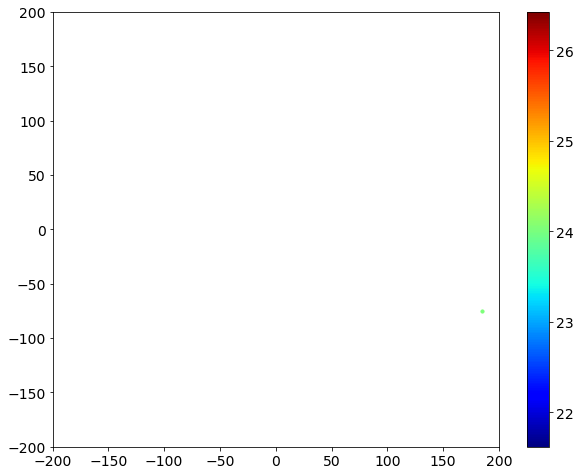

In [43]:
plot_sipm_map(sipm_cal)

### Event

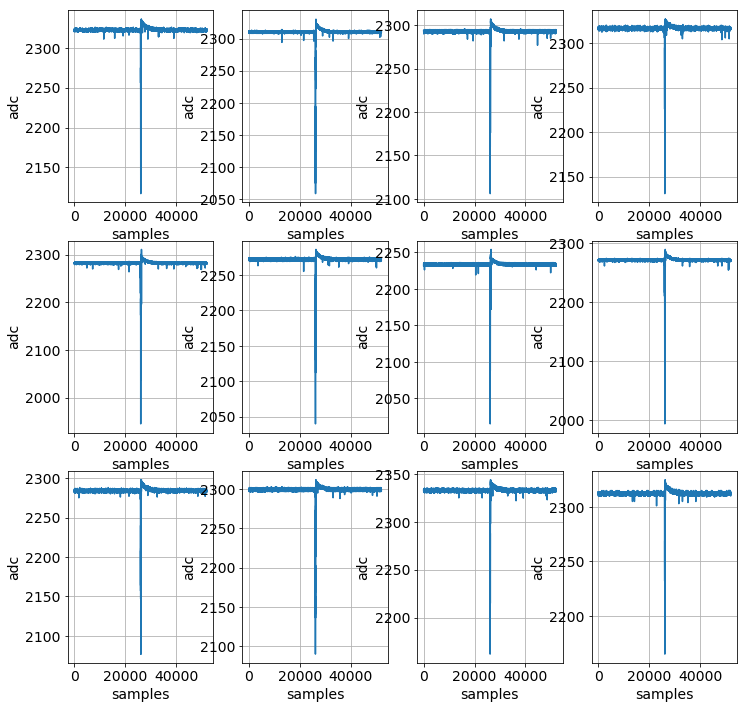

In [44]:
event=1
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

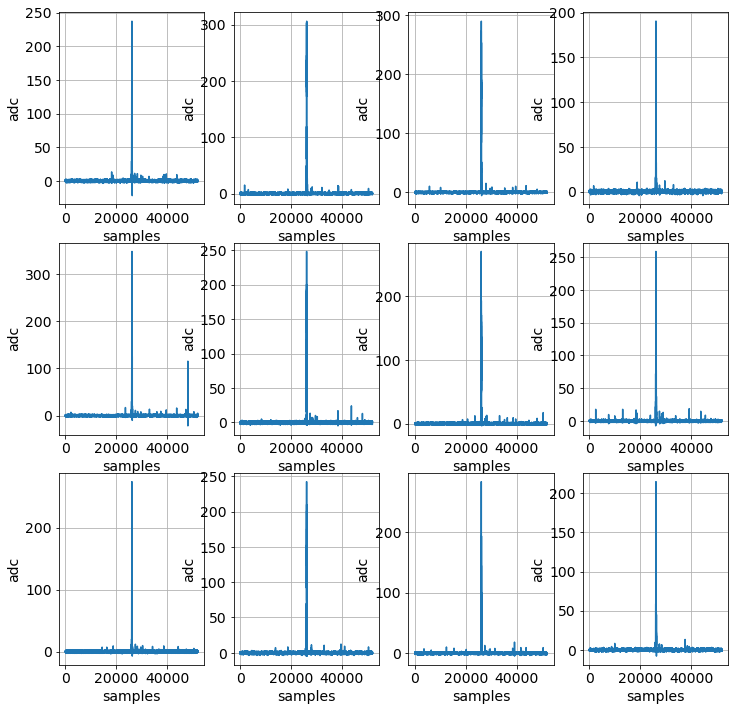

In [93]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=False, window_size=300, figsize=(12,12))

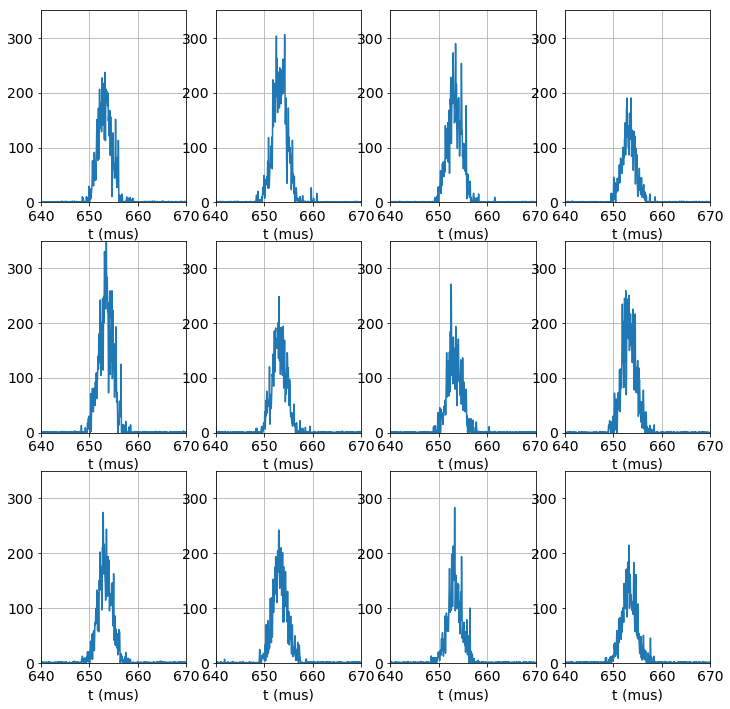

In [87]:
plot_pmt_signals_vs_time_mus(CWF,
                             pmt_active,
                            t_min      =640,
                            t_max      = 670,
                            signal_min =    0,
                            signal_max =  350,
                            figsize=(12,12))

In [88]:
CWF.shape

(12, 52000)

In [94]:
650*40

26000

In [97]:
sums = [np.sum(CWF[i][650*40:660*40]) / adc_to_pes[i] for i in range(12)]

In [98]:
sums

[1213.3791358488636,
 1425.694945699744,
 1105.1996164781212,
 709.30027849336705,
 1151.6538074504933,
 1077.0340064278246,
 854.13781521653584,
 858.99230687033457,
 1113.1524073501521,
 976.49282157459049,
 1020.4835463904884,
 929.25416893804936]

In [99]:
np.sum(sums)

12434.774856738564

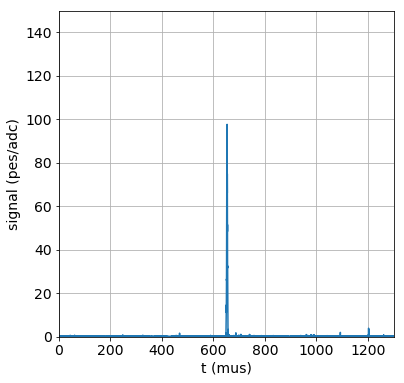

In [101]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  150,
                            figsize=(6,6))

In [102]:
cwf_sum.shape

(52000,)

In [104]:
np.sum(cwf_sum[650*40:660*40])

12434.774856738564

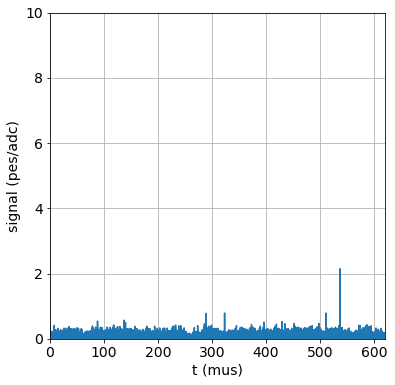

In [47]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 620,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [48]:
s1params = S12Params(time = minmax(min    = 160 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 11
       Times: [ 537.05   537.075  537.1    537.125  537.15   537.175  537.2    537.225
 537.25   537.275  537.3  ] µs
       Time @ max energy: 537.1
       Width: 0.25 µs
       Height: 2.1470474126832304 pes
       Energy: 13.720173020782623 pes
       Charge: 0.0 pes
       RMS: 0.06775778534698723 µs]

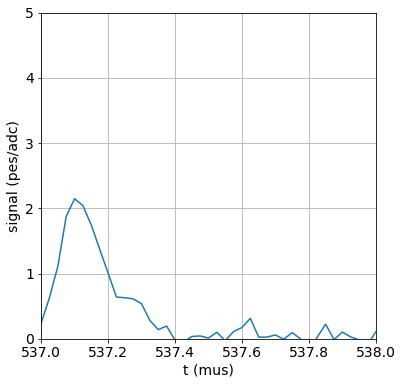

In [50]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =537,
                            t_max      = 538,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [105]:
s2params = S12Params(time = minmax(min    = 620 * units.mus,
                                   max    = 720 * units.mus),
                           stride = 40,
                           length = minmax(min = 4, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 648.59125187  649.65228384  650.58031278  651.5663353   652.51770585
 653.46734117  654.44711673  655.40526042  656.3423069   657.4453159
 658.38613864  659.61340121  660.5698313   661.49115878] µs
       Time @ max energy: 653.4673411663086
       Width: 12.899906915154657 µs
       Height: 3303.2197118901695 pes
       Energy: 12589.699733213625 pes
       Charge: 427.2373424961886 pes
       RMS: 1.4616641519514908 µs, 
 ---------------------
 S2 instance
 ---------------------
 Number of samples: 1
 Times: [ 687.37804079] µs
 Time @ max energy: 687.3780407867711
 Width: 0.0 µs
 Height: 13.203626425361913 pes
 Energy: 13.203626425361913 pes
 Charge: 0.0 pes
 RMS: 0.0 µs, 
 ---------------------
 S2 instance
 ---------------------
 Number of samples: 2
 Times: [ 698.89970582  699.21679509] µs
 Time @ max energy: 699.2167950857737
 Width: 0.3170892660006648 µs
 H

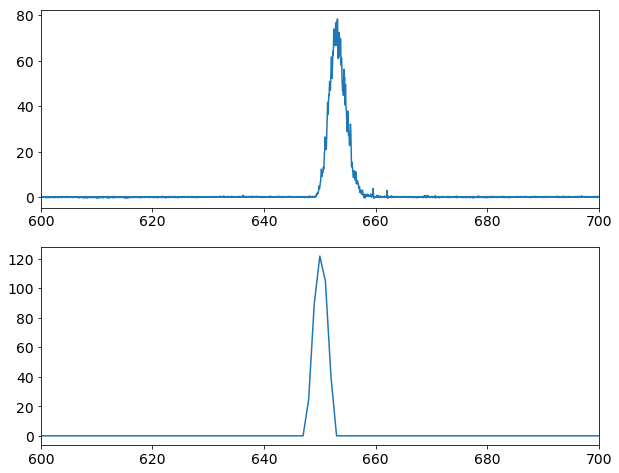

In [52]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=600, t_max=700)

[[475]
 [476]
 [483]
 [484]
 [485]
 [492]
 [493]]


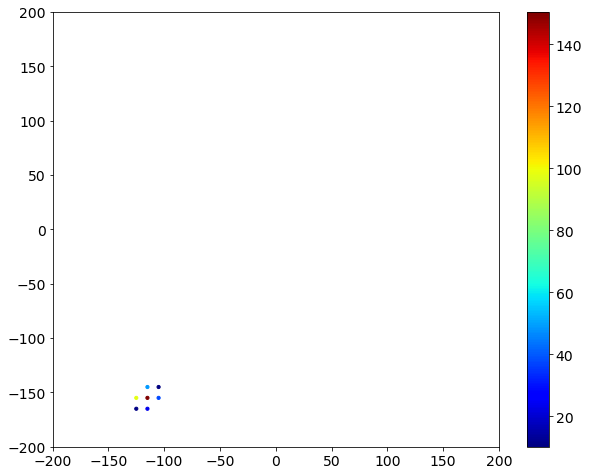

In [53]:
plot_sipm_map(sipm_cal)

### Event

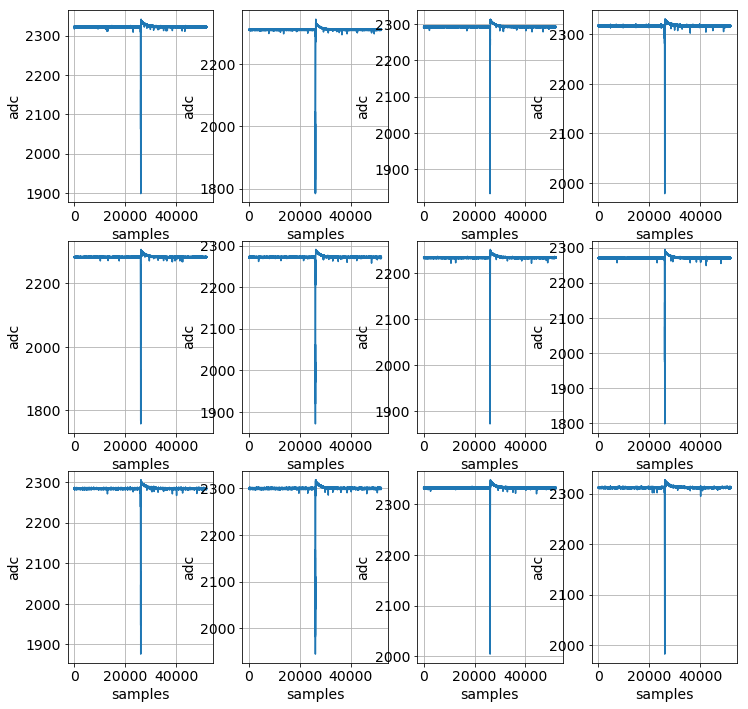

In [54]:
event=2
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

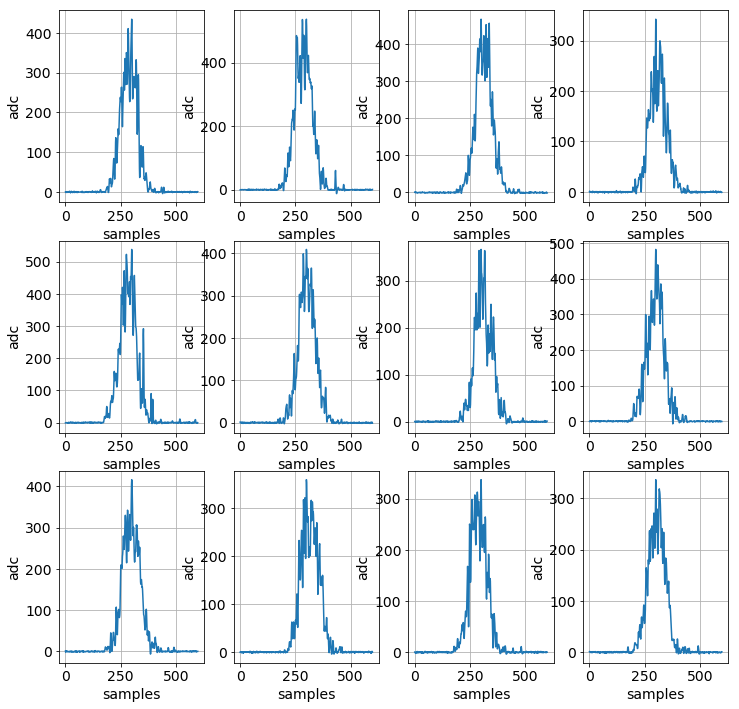

In [55]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=300, figsize=(12,12))

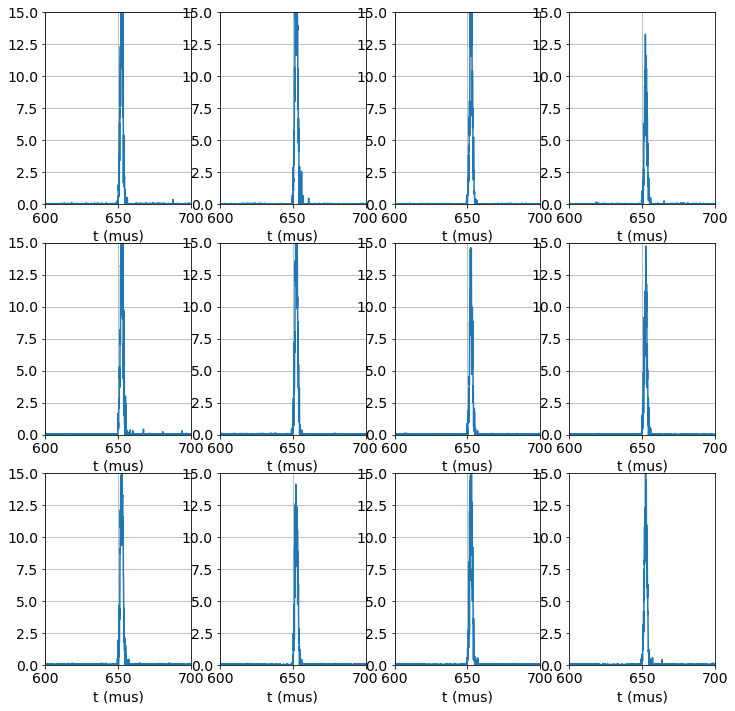

In [56]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    600,
                                t_max      = 700,
                                signal_min =    0,
                                signal_max =  15,
                                 figsize=(12,12))

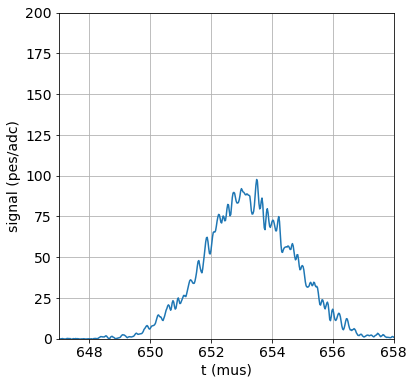

In [111]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =647,
                            t_max      = 658,
                            signal_min =    0,
                            signal_max =  200,
                            figsize=(6,6))

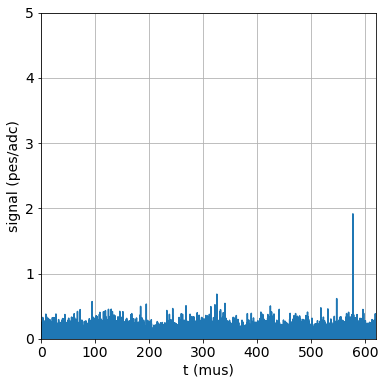

In [58]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 620,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

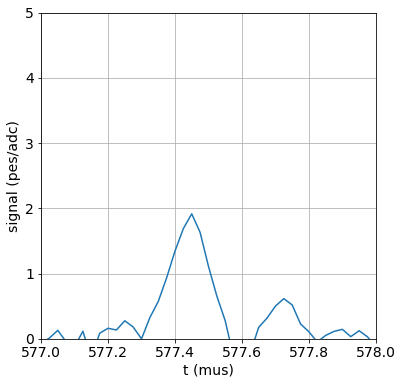

In [61]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =577,
                            t_max      = 578,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [59]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 577.375  577.4    577.425  577.45   577.475  577.5    577.525] µs
 Time @ max energy: 577.45
 Width: 0.15 µs
 Height: 1.915398382482904 pes
 Energy: 9.281944922272487 pes
 Charge: 0.0 pes
 RMS: 0.042835088060482245 µs]

In [113]:
s2params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 648.59125187  649.65228384  650.58031278  651.5663353   652.51770585
 653.46734117  654.44711673  655.40526042  656.3423069   657.4453159
 658.38613864  659.61340121  660.5698313   661.49115878] µs
       Time @ max energy: 653.4673411663086
       Width: 12.899906915154657 µs
       Height: 3303.2197118901695 pes
       Energy: 12589.699733213625 pes
       Charge: 427.2373424961886 pes
       RMS: 1.4616641519514908 µs]

In [114]:
np.sum(cwf_sum[648*40:661*40])

12588.809077628777

In [115]:
s2params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 11
       Times: [ 648.61080147  649.65228384  650.58031278  651.5663353   652.51770585
 653.46734117  654.44711673  655.40526042  656.3423069   657.4453159
 658.24577916] µs
       Time @ max energy: 653.4673411663086
       Width: 9.634977685221122 µs
       Height: 3303.2197118901695 pes
       Energy: 12567.834344042765 pes
       Charge: 427.2373424961886 pes
       RMS: 1.4384179544428142 µs]

In [118]:
np.sum(cwf_sum[648*40:659*40])

12577.093252299903

In [119]:
np.sum([np.sum(CWF[i][648*40:659*40]) / adc_to_pes[i] for i in range(12)])

12577.093252299905

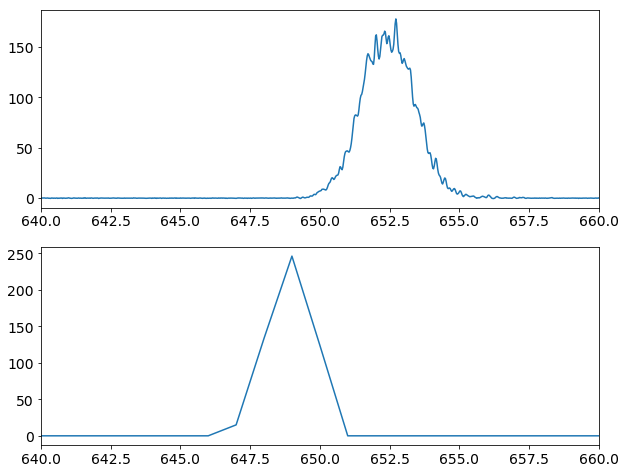

In [65]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=640, t_max=660)

[[  7]
 [685]
 [686]
 [687]
 [693]
 [694]
 [695]
 [702]
 [703]]


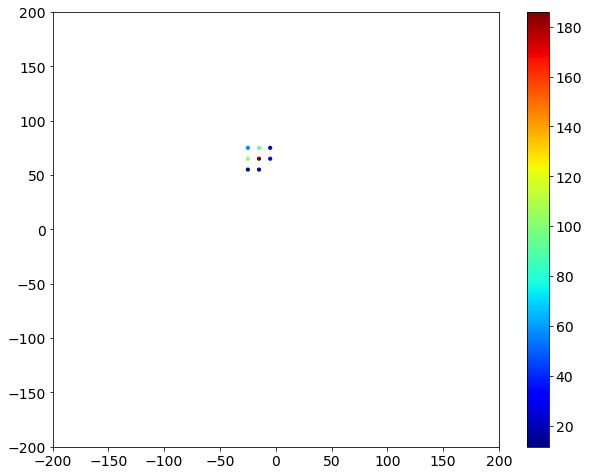

In [64]:
plot_sipm_map(sipm_cal)

### Event

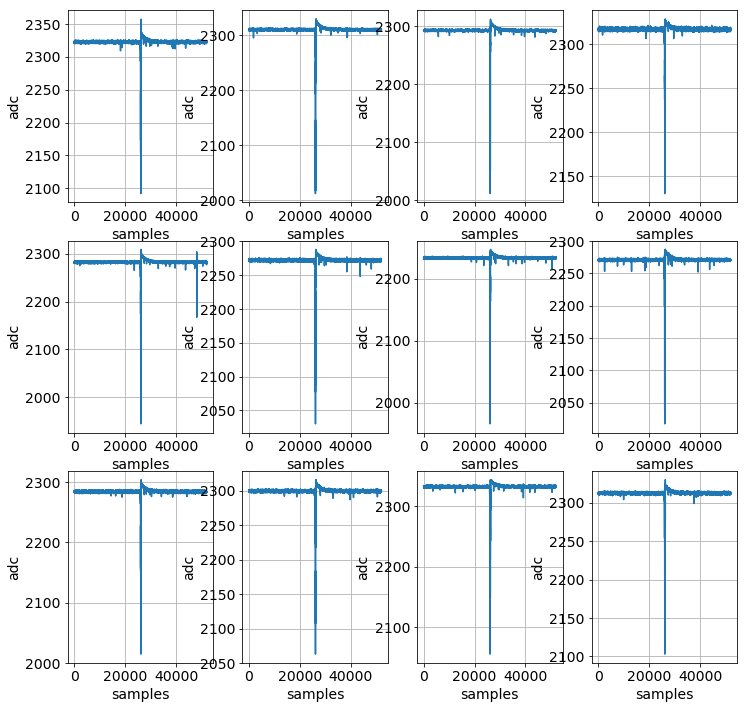

In [66]:
event=3
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

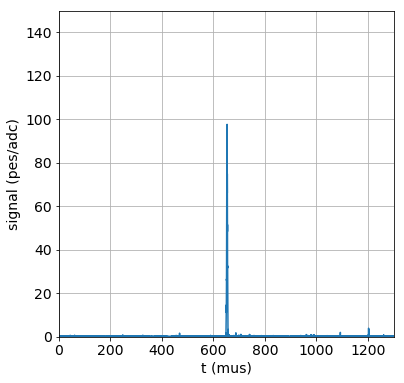

In [67]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  150,
                            figsize=(6,6))

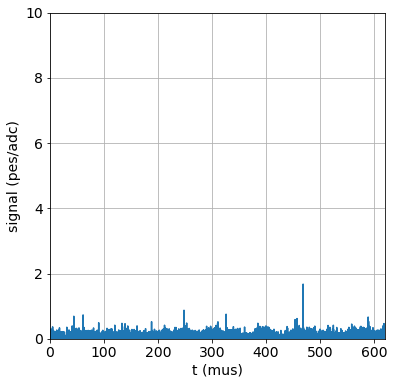

In [68]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 620,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

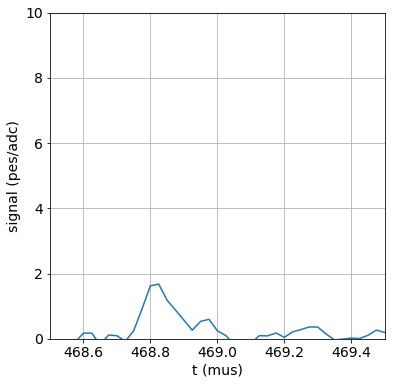

In [72]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =468.5,
                            t_max      = 469.5,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [73]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 468.775  468.8    468.825  468.85   468.875  468.9    468.925  468.95 ] µs
 Time @ max energy: 468.825
 Width: 0.175 µs
 Height: 1.6763374400260314 pes
 Energy: 7.651414639535338 pes
 Charge: 0.0 pes
 RMS: 0.0491315330067221 µs]

In [74]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 740 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 11
       Times: [ 648.61080147  649.65228384  650.58031278  651.5663353   652.51770585
 653.46734117  654.44711673  655.40526042  656.3423069   657.4453159
 658.24577916] µs
       Time @ max energy: 653.4673411663086
       Width: 9.634977685221122 µs
       Height: 3303.2197118901695 pes
       Energy: 12567.834344042765 pes
       Charge: 427.2373424961886 pes
       RMS: 1.4384179544428142 µs]

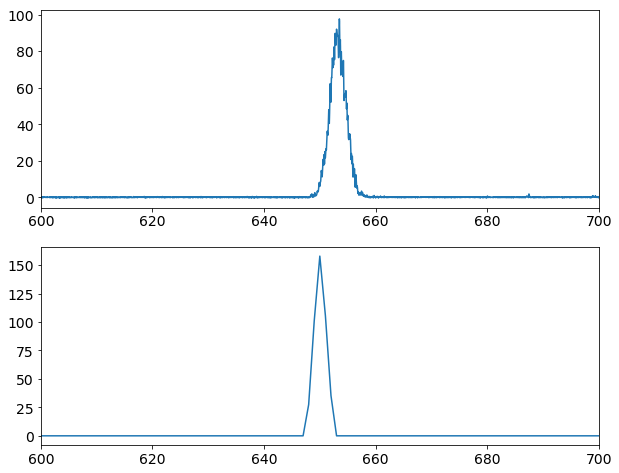

In [75]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=600, t_max=700)

[[  7]
 [186]
 [187]
 [188]
 [386]
 [387]
 [388]
 [395]
 [396]]


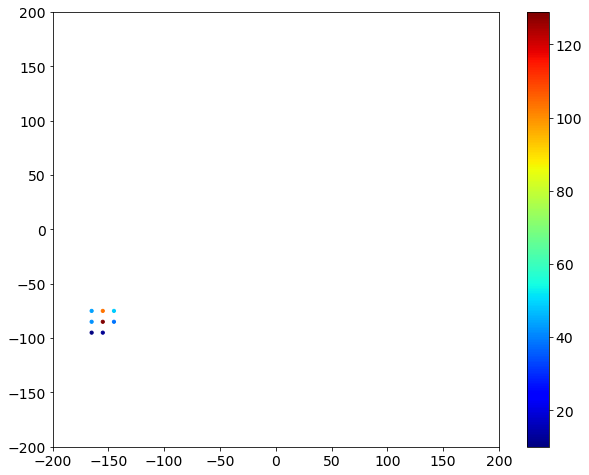

In [76]:
plot_sipm_map(sipm_cal)